In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install pydicom

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import os
import pydicom as dicom
from skimage import exposure
from skimage import transform
from skimage import io
from skimage import color
from scipy.ndimage import zoom
import cv2
from PIL import Image

import csv
import copy
import glob
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from torch import nn
from sklearn.metrics import f1_score

# Preprocessing

In [ ]:
path_train = '/content/drive/MyDrive/Progetto/CHAOS_Train_Sets/Train_Sets/MR'
path_test = '/content/drive/MyDrive/Progetto/CHAOS_Test_Sets/Test_Sets/MR'

In [ ]:
#loading dataset
dimensioni_vox = []
pazienti_img = []
pazienti_mask = []

for path, subfolder, files in sorted(os.walk(path_train)):
  img_vol = []
  mask_vol = []
  if path.endswith('InPhase'):
    for filename in sorted(files):
      img_dcm_std = dicom.dcmread(os.path.join(path,filename))
      img = img_dcm_std.pixel_array
      img_vol.append (img)

    z_space = img_dcm_std.SliceThickness
    x_space = img_dcm_std.PixelSpacing [0]
    y_space = img_dcm_std.PixelSpacing [1]
    vox_dim = (x_space, y_space, z_space)
    dimensioni_vox.append(vox_dim)

    img_vol_raw = np.array(img_vol)
    pazienti_img.append(img_vol_raw)

  if path.endswith('T1DUAL/Ground'):
    for filename in sorted(files):
      image = np.asarray(Image.open(os.path.join(path,filename)))
      mask_vol.append(image)

    mask_vol_raw = np.array(mask_vol)
    pazienti_mask.append(mask_vol_raw)

In [ ]:
#target parameters for resampling and resize
target_resolution = [1, 1, 1]
resolution = []
target_shape = [256,256,256]

for vox in dimensioni_vox:
  scale_vector = (vox[0]/target_resolution[0], vox[1]/target_resolution[1], vox[2]/target_resolution[2])
  resolution.append(scale_vector)

In [ ]:
#resampling and resizing of images
for i in range(0, 20):
  pazienti_img[i] = transform.rescale(pazienti_img[i], resolution[i], order=3, preserve_range=True, mode='constant')

  scale_vector = (target_shape[0]/pazienti_img[i].shape[0], target_shape[1]/pazienti_img[i].shape[1], target_shape[2]/pazienti_img[i].shape[2])
  pazienti_img[i] = zoom (pazienti_img[i], scale_vector, order=3, mode='nearest')

In [ ]:
#normalizing and equalizing images
norm_img = []
for x in pazienti_img:
  norm_image = cv2.normalize(x, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC1)
  norm_img.append(norm_image)

clahe = cv2.createCLAHE (clipLimit = 2.0, tileGridSize = (8, 8))

for i in range(0, len(norm_img)):
  for j in range(0, len(norm_img[i])):
    norm_img[i][j] = clahe.apply (norm_img[i][j, :, :])

In [ ]:
#creation of a custom dataset
#splitting images for trading and validation
os.mkdir ("/content/drive/MyDrive/Dataset4")
os.mkdir ("/content/drive/MyDrive/Dataset4/train")
os.mkdir ("/content/drive/MyDrive/Dataset4/train/image_train")
os.mkdir ("/content/drive/MyDrive/Dataset4/train/mask_train")
os.mkdir ("/content/drive/MyDrive/Dataset4/train/image_val")
os.mkdir ("/content/drive/MyDrive/Dataset4/train/mask_val")

z = 0
for i in range(1, len(norm_img)-3):
  for j in range(0, len(norm_img[i-1])):
    np.save("/content/drive/My Drive/Dataset4/train/image_train/" + str(z) + ".npy", norm_img[i-1][j]);
    z += 1

z = 0
for i in range(16, len(norm_img)+1):
  for j in range(0, len(norm_img[i-1])):
    np.save("/content/drive/My Drive/Dataset4/train/image_val/" + str(z) + ".npy", norm_img[i-1][j]);
    z += 1

del pazienti_img
del norm_img

In [ ]:
#resampling and resizing of masks
for i in range(0, 20):
  pazienti_mask[i] = transform.rescale(pazienti_mask[i], resolution[i], order=0, preserve_range=True, mode='constant')

  scale_vector = (target_shape[0]/pazienti_mask[i].shape[0], target_shape[1]/pazienti_mask[i].shape[1], target_shape[2]/pazienti_mask[i].shape[2])
  pazienti_mask[i] = zoom (pazienti_mask[i], scale_vector, order=0, mode='nearest')

In [ ]:
#splitting images for trading and validation
z = 0
for i in range(1, len(pazienti_mask)-3):
  for j in range(0, len(pazienti_mask[i-1])):
    np.save("/content/drive/My Drive/Dataset4/train/mask_train/" + str(z) + ".npy", pazienti_mask[i-1][j]);
    z += 1

z = 0
for i in range(16, len(pazienti_mask)+1):
  for j in range(0, len(pazienti_mask[i-1])):
    np.save("/content/drive/My Drive/Dataset4/train/mask_val/" + str(z) + ".npy", pazienti_mask[i-1][j]);
    z += 1

del pazienti_mask

In [ ]:
os.mkdir ("/content/drive/MyDrive/Dataset4/test")
test = []
z = 0
for path, subfolder, files in sorted(os.walk(path_test)):
  if path.endswith('InPhase'):
    for filename in sorted(files):
      img_dcm_std = dicom.dcmread(os.path.join(path,filename))
      img = img_dcm_std.pixel_array
      np.save("/content/drive/My Drive/Dataset4/test/" + str(z) + ".npy", img);
      z += 1

# Neural Network

In [4]:
# Helper function for visualizing some samples of the images/mask to controll overlap
def image_viewer(output_classes, image, mask):

    x=mask[0].numpy()
    x*=output_classes # The function need the classes to be integer
    io.imshow(color.label2rgb(x, image[0].numpy(), bg_label=0)) # Set bkg transparent and shows only
                                                                #  other classes on top of the input png
plt.show()

In [5]:
# Helper function for model semantic segmentation output
def decode_segmap(image, nc=5):
    label_colors = np.array([(0, 0, 0),      # 0=sfondo
                             (63, 63, 63),    # 1=Liver
                             (126, 126, 126),    # 2=Right kidney
                             (189, 189, 189),    # 3=Left kidney
                             (252, 252, 252)   # 4=Spleen
                                        ])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [6]:
# Dataset class loading input images and from two separate folders in numeric order
class SpineDataset(Dataset):

    def __init__(self, image_dir, mask_dir, channels_img, channels_masks, transform = None):
        self.image_dir = image_dir #  Getting image folder
        self.mask_dir = mask_dir  # Getting mask forlder
        self.transform = transform # If there are transformtion to apply
        self.channels_img = channels_img
        self.channels_masks = channels_masks
    def __len__(self):
        return len(glob.glob(os.path.join(self.image_dir,'*.npy'))) # number of images found in the folder

    def __getitem__(self,idx):
        img_name = os.path.join(self.image_dir,"%d.npy"%idx)
        img = np.load(img_name)
        tmp_img=np.ndarray((img.shape[0],img.shape[1], self.channels_img),dtype=np.uint8)
        for i in range(self.channels_img):
            tmp_img[:,:,i]=img

        mask_name = os.path.join(self.mask_dir,"%d.npy"%idx)
        mask = np.load(mask_name)
        tmp_mask=np.ndarray((mask.shape[0],mask.shape[1], self.channels_masks),dtype=np.uint8)
        for i in range(self.channels_masks):
            tmp_mask[:,:,i]=mask

        sample = {'image': tmp_img, 'mask': tmp_mask} # matched image and mask

        if self.transform:
            sample=self.transform(sample) # Eventual transformation to be made on the input data

        return sample

In [7]:
# Custom function to transform input data to tensor of shape Nc, H, W
class ToTensor(object):

    def __call__(self, sample):
        img, mask = sample['image'], sample['mask']
        if img.ndim == 3:
            mask = mask.transpose((2, 0, 1))
        if img.ndim == 3:
            img = img.transpose((2, 0, 1))
        return {'image': torch.from_numpy(img).type(torch.FloatTensor),
                'mask': torch.from_numpy(mask).type(torch.FloatTensor)}

In [8]:
# Input normalization to have image and mask in [0 1] based on data range and classes
class Normalize(object):

    def __call__(self, sample):
        img, mask = sample['image'], sample['mask']
        return {'image': img/255,
                'mask': mask/4.0}

In [9]:
# Freezing model to not retrain everything given the low dimensionality of the dataset
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [10]:
# Load. of pretrained model and change of last layer to match the number of classes to be predicted
# Newly added layer will be trained
def createModel(output_classes):
    my_model = models.segmentation.fcn_resnet101(pretrained = True)
    set_parameter_requires_grad(my_model, feature_extracting = True)
    my_model.classifier[4] = nn.Conv2d(512, output_classes, kernel_size=(1, 1), stride=(1, 1))
    my_model.aux_classifier[4] = nn.Conv2d(256, output_classes, kernel_size=(1, 1), stride=(1, 1))
    my_model.train()
    return my_model

In [11]:
# Function for model training
def train_model(model, criterion, dataloader, dataloader1, optimizer, metrics, bpath, num_epochs):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Logger
    fieldnames = ['epoch', 'Train_loss', 'Val_loss'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Val_{m}' for m in metrics.keys()]

    with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    for epoch in range(1, num_epochs+1):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs))

        batchsummary = {a: [0] for a in fieldnames}

        for phase in ['Train', 'Val']:
            if phase == 'Train':
                model.train()  # Set model to training mode
                dataloaders=dataloader # Select dataset for training
            else:
                model.eval()   # Set model to evaluate mode
                dataloaders=dataloader1 #Select dataste for validation

            # Iterate over data.
            for sample in tqdm(iter(dataloaders)):
                inputs = sample['image'].to(device)
                masks = sample['mask'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs['out'], masks)
                    y_pred = outputs['out'].data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()
                    for name, metric in metrics.items():
                        if name == 'f1_score':
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true > 0, y_pred > 0, average='weighted'))

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
            batchsummary['epoch'] = epoch
            epoch_loss = loss
            batchsummary[f'{phase}_loss'] = epoch_loss.item()
            print('{} Loss: {:.4f}'.format(
                phase, loss))
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(batchsummary)
        with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow(batchsummary)
            # deep copy the model
            if phase == 'Val' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [16]:
def main():
    path = '/content/drive/MyDrive/Dataset4/train/'
    channels_img = 3
    channels_masks = 5
    output_classes = 5
    batch_size = 32
    num_epochs = 5
    lr = 0.01

    #dataset and loader
    transformed_dataset_train = SpineDataset(image_dir = path + 'image_train/', mask_dir = path + 'mask_train/', channels_img = channels_img, channels_masks = channels_masks,
                                            transform = transforms.Compose([Normalize(),ToTensor()]))
    transformed_dataset_val = SpineDataset(image_dir = path + 'image_val', mask_dir = path + 'mask_val/', channels_img = channels_img, channels_masks = channels_masks,
                                            transform = transforms.Compose([Normalize(),ToTensor()]))

    # Visual evaluation of correct alignement between image and mask
    fig = plt.figure(figsize=(6,6))

    sample = transformed_dataset_train[100]
    a = fig.add_subplot(1,3,1)
    a.axis('off')
    image_viewer(output_classes, **sample)

    sample = transformed_dataset_train[170]
    a = fig.add_subplot(1,3,2)
    a.axis('off')
    image_viewer(output_classes, **sample)

    sample = transformed_dataset_train[2000]
    a = fig.add_subplot(1,3,3)
    a.axis('off')
    image_viewer(output_classes, **sample)

    plt.show()

    dataloader = DataLoader(transformed_dataset_train, batch_size, shuffle = True)
    dataloader1 = DataLoader(transformed_dataset_val, batch_size, shuffle=False)

    # Model creation and criterion, optimizer and metric
    my_model = createModel(output_classes)
    criterion = torch.nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(my_model.parameters(), lr)
    metrics = {'f1_score': f1_score}
    bpath = '/content/drive/MyDrive/Dataset4/train/'
    # Model training
    my_model_trained=train_model(my_model, criterion, dataloader, dataloader1, optimizer, metrics, bpath, num_epochs)

    # Getting first batch of the training data to run the model and see its performance
    for i_batch, sample_batched in enumerate(dataloader):
        print(i_batch, sample_batched['image'].size(),
          sample_batched['mask'].size())
        break

    # Visualization of the model output on one example image from training
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    sample_batched['image'] = sample_batched['image'].to(device)
    out = my_model_trained(sample_batched['image'])['out']
    out_c = out.cpu()
    for i in range(0,10):
      om = torch.argmax(out_c[i], dim=0).numpy()
      rgb = decode_segmap(om)
      plt.imshow(rgb)
      plt.show()

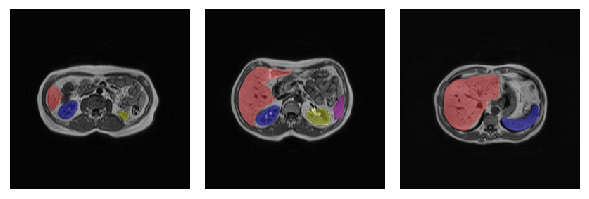

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
Epoch 1/5


100%|██████████| 128/128 [23:27<00:00, 10.99s/it]


Train Loss: 10.3471


100%|██████████| 40/40 [10:20<00:00, 15.51s/it]


Val Loss: 3.2401
{'epoch': 1, 'Train_loss': 10.3471097946167, 'Val_loss': 3.240104913711548, 'Train_f1_score': 0.6342012351497442, 'Val_f1_score': 0.605665459918462}
----------
Epoch 2/5


100%|██████████| 128/128 [13:03<00:00,  6.12s/it]


Train Loss: 9.7539


100%|██████████| 40/40 [03:56<00:00,  5.91s/it]


Val Loss: 3.2394
{'epoch': 2, 'Train_loss': 9.753863334655762, 'Val_loss': 3.2394466400146484, 'Train_f1_score': 0.6143249672201162, 'Val_f1_score': 0.5953913560811568}
----------
Epoch 3/5


100%|██████████| 128/128 [12:59<00:00,  6.09s/it]


Train Loss: 7.8906


100%|██████████| 40/40 [03:57<00:00,  5.93s/it]


Val Loss: 3.2392
{'epoch': 3, 'Train_loss': 7.890617370605469, 'Val_loss': 3.2392163276672363, 'Train_f1_score': 0.598159326144472, 'Val_f1_score': 0.5820704574444916}
----------
Epoch 4/5


100%|██████████| 128/128 [13:06<00:00,  6.14s/it]


Train Loss: 9.4563


100%|██████████| 40/40 [03:59<00:00,  5.98s/it]


Val Loss: 3.2392
{'epoch': 4, 'Train_loss': 9.456319808959961, 'Val_loss': 3.2391581535339355, 'Train_f1_score': 0.5861226239857306, 'Val_f1_score': 0.5697057622259379}
----------
Epoch 5/5


100%|██████████| 128/128 [13:00<00:00,  6.10s/it]


Train Loss: 8.8513


100%|██████████| 40/40 [03:53<00:00,  5.83s/it]


Val Loss: 3.2391
{'epoch': 5, 'Train_loss': 8.851251602172852, 'Val_loss': 3.239142417907715, 'Train_f1_score': 0.5751805610026954, 'Val_f1_score': 0.5686691723577856}
0 torch.Size([32, 3, 256, 256]) torch.Size([32, 5, 256, 256])


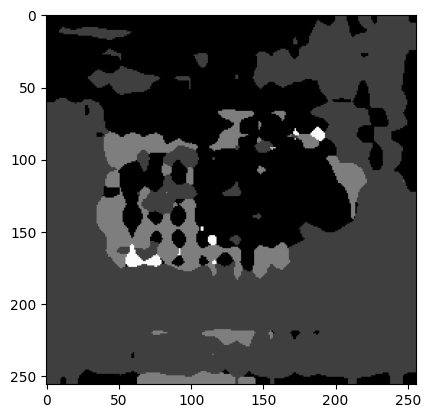

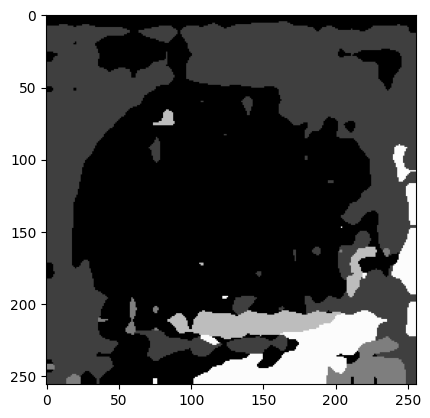

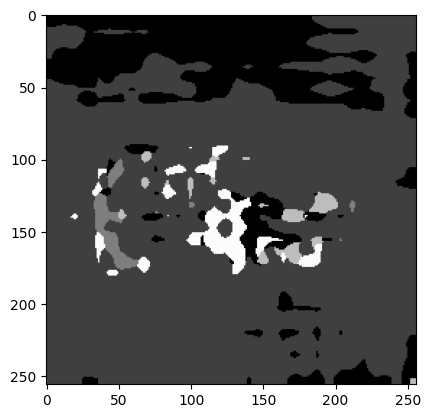

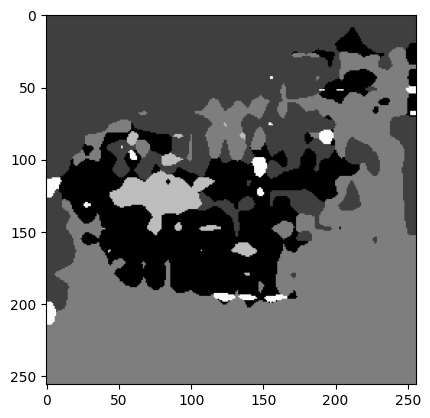

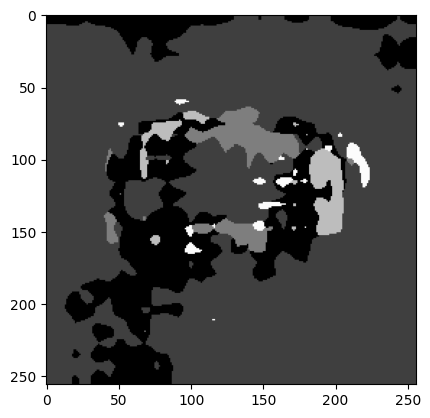

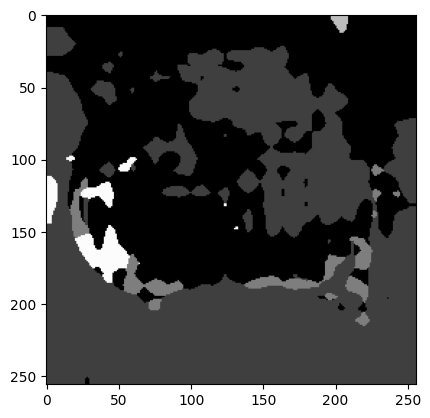

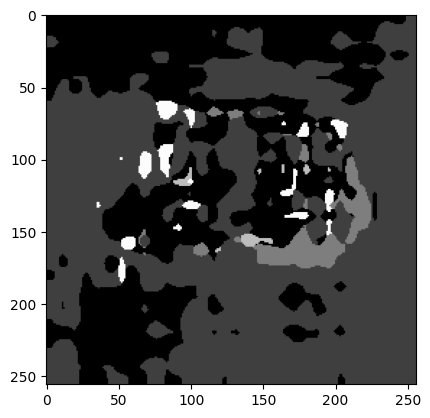

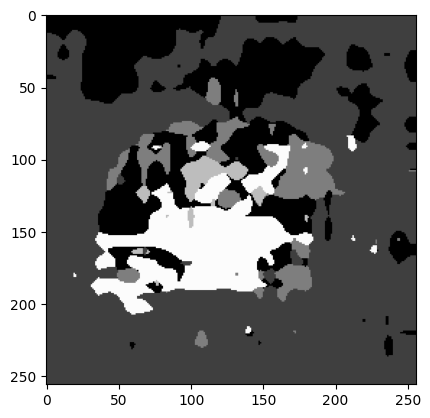

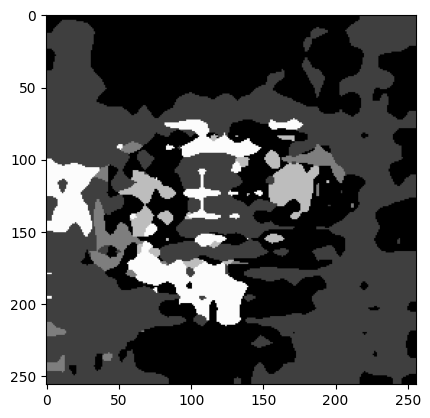

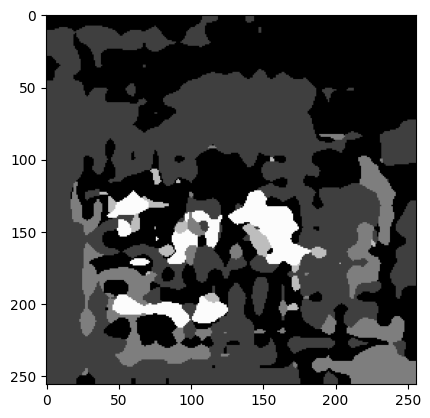

In [17]:
main()